In [1]:
import glob,os
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [2]:
# Text Processing Functions
def preprocess(s, lowercase=True, strip_punctuation=True):
    """
    Input:
        string s
        boolean lowercase
        boolean strip_punctuation
    Return:
        list of strings
    """
    punctuation = '.,?<>:;"\'!%'
    if isinstance(s, str):
        s = s.split() # split string into tokens
    if lowercase:
        s = [t.lower() for t in s]
    if strip_punctuation:
        s = [t.strip(punctuation) for t in s]
        
    return s

def token_frequency(tokens, tf= None, relative=False):
    """
    Inputs: 
        tokens = List of Strings or None
        tf = dict or None
        relative = Boolean
    Output: 
        Dictionary of a token frequencies
    """
    tf = {} if tf==None else tf
    
    if len(tf) != 0 and relative==True:
        if isinstance(list(tf.items())[0][1], float):
            print('WARNING: Adding raw counts to relative frequency')
            return tf
        
    for token in tokens:
        if token in tf:
            tf[token] += 1
        else:
            tf[token] = 1
    
    if relative:
        total = sum([v for k,v in tf.items()])
        tf = {k:v/total for k, v in tf.items()}
          
    return tf


def get_tokens(filenames):
    for file in filenames:
        text = preprocess(open(file,'r').read())
        yield text

In [3]:
# Get file paths to texts
filenames = glob.glob('data/*.txt')
labels = [os.path.split(file)[1][:-4].title() for file in filenames] # extract labels from file paths

In [17]:
# Find Document Frequency of all tokens in corpus
def mycount(corpus_freqs, token):
    corpus_freqs[token]+=1

doc_freqs = defaultdict(int) # define document frequency dictionary

# loop through all tokens and calc document frequency
[mycount(doc_freqs, token) for text in get_tokens(filenames) for token in set(text)]

# sort to get top document frequencies 
sorted_doc_freqs = {k:v for k,v in sorted(doc_freqs.items(), key=lambda x: x[1], reverse=True)}

# store top 70 tokens with highest document frequency
topn = 50
top_words = [word for word,c in list(sorted_doc_freqs.items())[:topn]]

In [18]:
# get relative token frequencies for each text in corpus 
rel_freqs = [token_frequency(tokens,relative=True) for tokens in get_tokens(filenames)]

# filter freqs to only include words in top words of the entire corpus
filtered_freqs = [{k:v for k,v in freq.items() if k in top_words} for freq in rel_freqs]

In [19]:
vectors_df = pd.DataFrame(filtered_freqs,index=labels).fillna(0)
vectors_df.head()

,asleep,belt,between,beyond,bound,breathe,candles,clutched,crowded,decided,...,shouted,simply,sit,starting,swept,temper,today,turn,year,young
Tolkien_Lor2,0.000149,0.000078,0.000589,0.000699,0.000110,0.000026,0.000032,0.000052,0.000006,0.000006,...,0.000155,0.000013,0.000168,0.000013,0.000084,0.000006,0.000078,0.000317,0.000129,0.000317
Tolkien_Lor3,0.000103,0.000066,0.000509,0.000797,0.000074,0.000030,0.000022,0.000044,0.000007,0.000030,...,0.000103,0.000007,0.000133,0.000030,0.000066,0.000007,0.000074,0.000281,0.000214,0.000199
Tolkien_Lor1,0.000149,0.000096,0.000568,0.000812,0.000096,0.000027,0.000053,0.000021,0.000042,0.000117,...,0.000133,0.000037,0.000111,0.000032,0.000069,0.000005,0.000111,0.000313,0.000234,0.000244
Got1,0.000058,0.000092,0.000599,0.000291,0.000055,0.000021,0.000046,0.000049,0.000092,0.000076,...,0.000254,0.000028,0.000153,0.000021,0.000070,0.000018,0.000104,0.000242,0.000153,0.000367
Got2,0.000068,0.000061,0.000544,0.000176,0.000096,0.000040,0.000028,0.000049,0.000059,0.000101,...,0.000251,0.000026,0.000103,0.000021,0.000080,0.000021,0.000059,0.000241,0.000150,0.000420


In [20]:
n_clusters=3  # define number of clusters
# create a kmeans model fitted to our dataframe
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(vectors_df)

# use PCA to shrink down dimensions
pca = PCA(n_components=2) # define how much dimensions to shrink down to
transformed = pca.fit_transform(vectors_df)

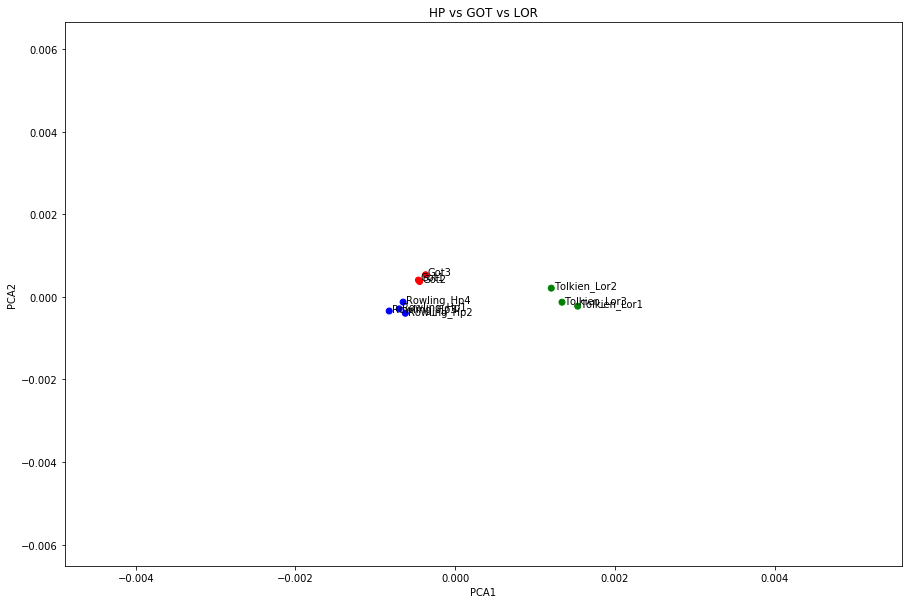

In [33]:
# define x and y data
x = transformed[:,0]
y = transformed[:,1]

# define colors and labels
col_dict = {0:'red', 1:'blue', 2:'green'}
cols = [col_dict[l] for l in kmeans.labels_]

# create scatter plot
plt.figure(figsize=(15,10))
plt.scatter(x,y, c=cols)

# add text labels
for i, l in enumerate(labels):
     plt.text(x[i]+.00003,y[i]-.00001, l)
# for i, c in enumerate(pca.components_.transpose()[:10]):
#     plt.arrow(0,0, c[0]/50, c[1]/50, alpha=.3, width=.00001)
#     plt.text(c[0]/50, c[1]/50, top_words[i])
# plot clusters
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('HP vs GOT vs LOR')
plt.show()